In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC


In [5]:
class Trainer:

    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def train(self):
        self.model.fit(self.X_train,self.y_train)
    
    def predict(self,x):
        return self.model.predict(x)
    
    def metrics(self):
        pred = self.predict(self.X_test)
        print(f"Accuracy: {accuracy_score(self.y_test,pred)}")
        print(f"F1 score: {f1_score(self.y_test,pred,average='macro')}")
    
    def confusion_matrix(self):
        pred = self.predict(self.X_test)
        ConfusionMatrixDisplay.from_predictions(self.y_test,pred,cmap=plt.cm.Blues)
        plt.grid(False)
        plt.show()

In [6]:
df = pd.read_csv("../proc_data/cstr.csv")
print(df.head())
y = df['class']
X = df.drop('class', axis=1)

   Unnamed: 0   feature1   feature2  class
0           0  41.322630  10.776732    0.0
1           1  40.282010  12.140834    0.0
2           2  43.180370  11.824053    0.0
3           3  42.052227  15.140845    0.0
4           4  41.748140  16.027851    0.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
np.unique(y_test, return_counts=True)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([36, 45, 55, 39, 58, 43, 40, 40, 38, 44, 48, 35, 51]))

In [9]:
np.unique(y_train, return_counts=True)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([184, 175, 165, 181, 162, 177, 180, 180, 182, 176, 172, 185, 169]))

### SVM

In [10]:
model = SVC(random_state=0)
svc_trainer = Trainer(model, X_train, X_test, y_train, y_test)
svc_trainer.train()

In [11]:
svc_trainer.metrics()

Accuracy: 0.7884615384615384
F1 score: 0.7922916411210725


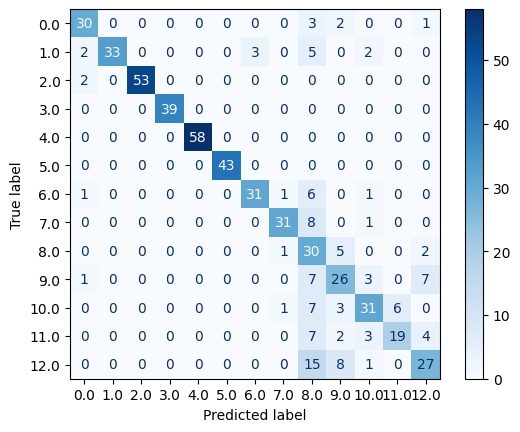

In [12]:
svc_trainer.confusion_matrix()

#### Finetuning hyperparams

In [13]:
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto', 0.1, 1],
              'degree': [2, 3, 4],
              'coef0': [0.0, 1.0],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}
              
svm_classifier = SVC()

svm_grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='f1_weighted', cv=5)
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'coef0': [0.0, 1.0],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='f1_weighted')

In [14]:
svm_results_df = pd.DataFrame(svm_grid_search.cv_results_)
svm_results_df = svm_results_df[['params', 'mean_test_score', 'std_test_score']]
svm_results_df.rename(columns={'params': 'Parameters', 'mean_test_score': 'Mean F1 Score', 'std_test_score': 'Std F1 Score'},
                  inplace=True)
svm_results_df_top = svm_results_df.sort_values(by='Mean F1 Score', ascending=False).head(10)
pd.set_option('display.max_colwidth', None)
print("Best parameters found: ", svm_grid_search.best_params_)
print(svm_results_df_top)


Best parameters found:  {'C': 100, 'class_weight': None, 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
                                                                                                                             Parameters  \
1342        {'C': 100, 'class_weight': None, 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 4, 'gamma': 1, 'kernel': 'poly'}   
1294        {'C': 100, 'class_weight': None, 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 1, 'kernel': 'poly'}   
1534  {'C': 100, 'class_weight': 'balanced', 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 4, 'gamma': 1, 'kernel': 'poly'}   
1486  {'C': 100, 'class_weight': 'balanced', 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 1, 'kernel': 'poly'}   
1453   {'C': 100, 'class_weight': 'balanced', 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}   
1373   {'C': 100, 

Accuracy on test set: 0.88
F1 score on test set: 0.88


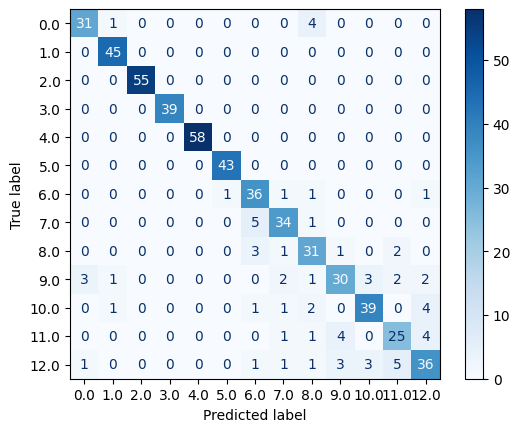

In [15]:
best_svm = svm_grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy on test set: {:.2f}".format(accuracy))
print("F1 score on test set: {:.2f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### Random Forest

Accuracy: 0.9475524475524476
F1 score: 0.9451581237665442


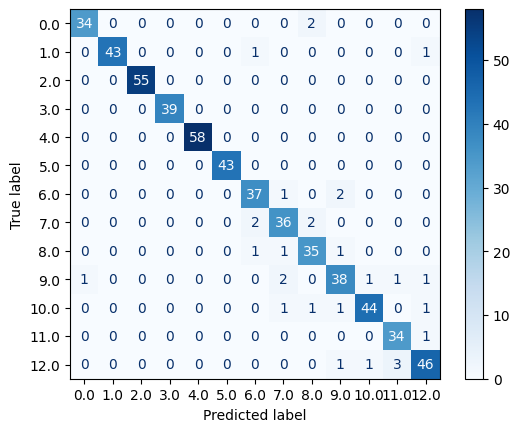

In [16]:
model = RandomForestClassifier(random_state=0)
forest_trainer = Trainer(model, X_train, X_test, y_train, y_test)
forest_trainer.train()
forest_trainer.metrics()
forest_trainer.confusion_matrix()

#### Finetuning hyperparams

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.1, 0.2],  
    'criterion': ['gini', 'entropy']  
}

rf_classifier = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='f1_weighted', cv=5)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted')

In [18]:
rf_results_df = pd.DataFrame(rf_grid_search.cv_results_)
rf_results_df = rf_results_df[['params', 'mean_test_score', 'std_test_score']]
rf_results_df.rename(columns={'params': 'Parameters', 'mean_test_score': 'Mean F1 Score', 'std_test_score': 'Std F1 Score'},
                  inplace=True)
rf_results_df_top = rf_results_df.sort_values(by='Mean F1 Score', ascending=False).head(10)
pd.set_option('display.max_colwidth', None)
print("Best parameters found: ", rf_grid_search.best_params_)
print(rf_results_df_top)


Best parameters found:  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
                                                                                                                            Parameters  \
163    {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}   
190    {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}   
109  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}   
164    {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}   
194    {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}   
113  {'ccp_alpha': 0

Accuracy on test set: 0.95
F1 score on test set: 0.95


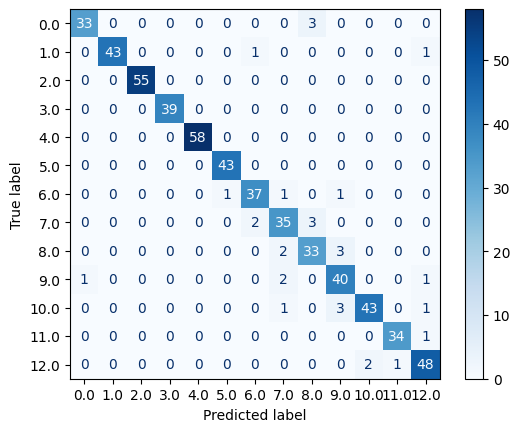

In [19]:
best_rf = rf_grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy on test set: {:.2f}".format(accuracy))
print("F1 score on test set: {:.2f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### Ensemble model

#### Top 10 models each

Accuracy: 0.9230769230769231
F1 score: 0.9187809951970398


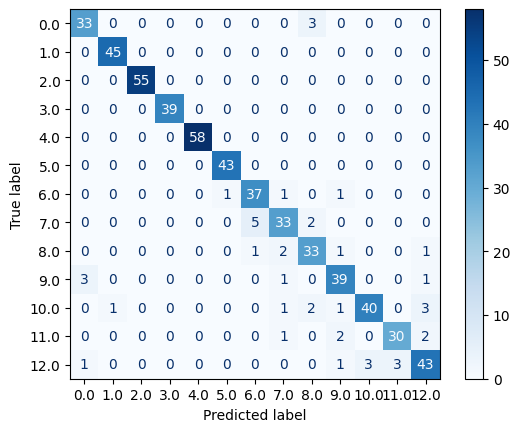

In [20]:
rf_top_params = rf_results_df_top['Parameters'].values
rf_models = [RandomForestClassifier(**params) for params in rf_top_params]
svm_top_params = svm_results_df_top['Parameters'].values
svm_models = [SVC(**params) for params in svm_top_params]
models = rf_models + svm_models

ensemble_model = VotingClassifier(estimators=[(f'model_{i}', model) for i, model in enumerate(models)], voting='hard')
ensemble_trainer = Trainer(ensemble_model, X_train, X_test, y_train, y_test)
ensemble_trainer.train()

ensemble_trainer.metrics()
ensemble_trainer.confusion_matrix()